In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append("C:/Users/Leon/Documents/AI_project/AI_project")
from Image_processing.Preprocessing.utils import preprocessing as prep

***Show the Image***

In [72]:
import importlib
importlib.reload(prep)

<module 'Image_processing.Preprocessing.utils.preprocessing' from 'C:\\Users/Leon/Documents/AI_project/AI_project\\Image_processing\\Preprocessing\\utils\\preprocessing.py'>

***height (rows), width(cols)***

Load images from storage and pass them through the preprocessing pipeline. The individual steps are:<br>
- Read Image as BGR Format<br>
- Resize Image to square format<br>
- Draw bounding box around the object in the image and convert it to RGB<br>
- get Hight and Width from the bounding box<br>
- check If the box is rotated and depending on that crop the area of the bounding box out of the image<br>
- Do Object Segmentation on the cropped image and return the binary segmented img (mask)<br>
- Get the segmented cropped RGB image<br>
- Place a green mask on the segmented cropped RGB image and get only the green pixels<br>
- Calculate the color from the segmented cropped RGB image with kmeans algorithm. Set k=2<br>
- Write the desired features to the dataframe

In [69]:
folders = ["Kartoffel", "Karotte", "Zwiebel", "Karotte_Trieb", "Zwiebel_Trieb", "Kartoffel_Trieb"]
#folders = ["Internet"]
paths = []
for fold in folders:
    for i, fname in enumerate(os.listdir(f"G:/Meine Ablage/KI_Projekt/Bilder/{fold}"), 1):
        paths.append(f"G:/Meine Ablage/KI_Projekt/Bilder/{fold}/{fname}")
        if i == 25:
            break
paths[25:50]  

['G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_1.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_2.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_3.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_4.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_5.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_6.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_7.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_8.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_9.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_10.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_11.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_12.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_13.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_14.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_15.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_16.jpg',
 'G:/Meine Ablage/KI_Projekt/Bild

In [66]:
demo_img = ['G:/Meine Ablage/KI_Projekt/Bilder/Karotte_Trieb/karotte_trieb_19.jpg', #karotte_trieb_17
            'G:/Meine Ablage/KI_Projekt/Bilder/Karotte_Trieb/karotte_trieb_19.jpg'] # 209 previous karotte_trieb Trainingsdaten
paths = demo_img

In [73]:
vegis_df = pd.DataFrame(columns=["Hight", "Width", "R", "G", "B", "green pixels",
                                 "green onion pixels", "ratio area", "circularity", 
                                 "keypoints", "mean keypoints", "Label", "Image"])
error_counter = 0
resize_counter = 0
for i, path in enumerate(paths):
    if 'desktop.ini' in path:
        continue

    ############################# Label the image ##################################
    vegi_label = path.split("/")[4]
 
    vegi_BGR = cv2.imread(path) # As BGR
    vegi_sq_BGR_original = prep.resize_to_square(vegi_BGR) # BGR

    #try:
    ############################# Find Contours in image and draw a bounding box ##################################
    vegi_with_box_rgb, more_than_one_box, box, rect, area, circularity = prep.draw_contours(vegi_sq_BGR_original, object_area=500)
    if more_than_one_box:
        box_size = 500
        while more_than_one_box:  # makes sure there is only one bounding box in the image
            box_size += 250
            vegi_with_box_rgb, more_than_one_box, box, rect, area, circularity = prep.draw_contours(vegi_sq_BGR_original, box_size)

    ############################# Get pixel size from the bounding box (hight and width) ##################################
    #FIXME height and width are swapped. Use width and height from rect=(width, height)
    h, w = [int(l) for l in prep.get_size_box(box)]
    
    ############################# Calculate the Ratio Area Feature ##################################
    ratio_area_box = 0
    if h > 0 and w > 0:
        ratio_area_box = area / (h * w)

    ############################# Crop the including area from the bounding box (our ROI) ##################################
    if not prep.is_box_rotated(box):
        #crop img directly
        # the top left corner should be the first element in box array
        cropped_vegi_BGR = vegi_sq_BGR_original[box[0][1]:box[0][1]+h, box[0][0]:box[0][0]+w]
        
    else:
        cropped_vegi_BGR = prep.crop_roi(vegi_sq_BGR_original, box) # BGR

    ############################# Do a binary segmentation only with the roi  ##################################
    cropped_segmented_binary_2 = prep.segment_img_2(cropped_vegi_BGR)
    #print("Segmented BINARY From Cop NEW")
    #show_image_plt(cropped_segmented_binary_2)

    ############################# Apply the binary mask on the cropped image  ##################################
    cropped_vegi_segmented_rgb_2 = prep.color_from_segmented_binary(cropped_segmented_binary_2, cropped_vegi_BGR) # center has rgb format
    #print("Segmented RGB")
    #show_image_plt(cropped_vegi_segmented_rgb_2)

    ##################### SIFT Algorithm - Calculates the mean keypoints and number of keypoints features #######################################
    num_kps, mean_kps = prep.sift(vegi_sq_BGR_original)

    ############################# Apply a green mask on the image ##################################
    # Seems to be work best
    vegi_only_onion_tribe_rgb, onion_tribe_mask = prep.mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(25, 40, 20), higher_thresh=(60, 160, 255))
    #print("ONLY GREEn TRIBE MASK")
    #show_image_plt(vegi_only_onion_tribe_rgb)
    vegi_only_tribe_rgb, tribe_mask = prep.mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(27, 105, 20), higher_thresh=(120, 255, 255))
    ############################# Calculates the number of green pixels feature  ##################################
    amount_green_pixels_onion_tribe = prep.count_green_pixels(onion_tribe_mask)
    amount_green_pixels_tribe = prep.count_green_pixels(tribe_mask)
    ############################# Get the Color (R, G, B) Feature(s) with a kmean algorithm ##################################
    center, ret, label = prep.get_color(cropped_vegi_segmented_rgb_2) #Center = RGB
    R, G, B = np.max(center, axis=0)
    
    a = path.split(".")
    b = a[0].split("_")
    img_name = f"{vegi_label}_{b[-1]}"
    vegis_df.loc[len(vegis_df)] = [h, w, R, G, B, amount_green_pixels_tribe, amount_green_pixels_onion_tribe, ratio_area_box, circularity, num_kps, mean_kps, vegi_label, img_name]
    print(img_name)
    if i < 3:
        print(vegis_df)

    # check if any points are outside of the image if yes move them within the img boundaries
    resized_box = prep.recalculate_bounding_box(box)
    rotated_points = prep.rotate_edge_points(resized_box, rect[2])
    aligned_points = prep.align_edge_points(rotated_points)
    aligned_points = [(prep.clip_aligned_points(x), prep.clip_aligned_points(y)) for x,y in aligned_points]

    # rotate img and draw new bounding box
    rotated_img = prep.rotate_img(vegi_with_box_rgb, rect[2])
    vegi_with_new_box_rgb = prep.draw_rotated_box(rotated_img, aligned_points)
    
    cv2.imwrite(f"G:/Meine Ablage/KI_Projekt/Bilder/Debugging_resize_function_v3/{img_name}_{i}.jpg", cv2.cvtColor(vegi_with_new_box_rgb, cv2.COLOR_BGR2RGB))
    
    """
    try:
        new_img, new_box = prep.resize_bound_box_and_draw(vegi_with_box_rgb, rect, box)
        #cv2.imwrite(f"G:/Meine Ablage/KI_Projekt/Bilder/Debugging_resize_function/{img_name}_{i}.jpg", new_img)
    except Exception as e:
        resize_counter += 1
        print(e)
    """ 
    #except Exception as e:
    #    print(f"########## Error: {e}")
    #    error_counter += 1
    

Kartoffel_1
   Hight  Width    R    G   B  green pixels  green onion pixels  ratio area  \
0    191     85  141  117  91             0                   0    0.729042   

   circularity  keypoints  mean keypoints      Label        Image  
0     0.574953         40       11.697907  Kartoffel  Kartoffel_1  
Kartoffel_2
   Hight  Width    R    G   B  green pixels  green onion pixels  ratio area  \
0    191     85  141  117  91             0                   0    0.729042   
1    193     80  141  117  91             0                   0    0.751392   

   circularity  keypoints  mean keypoints      Label        Image  
0     0.574953         40       11.697907  Kartoffel  Kartoffel_1  
1     0.566709         41       11.196103  Kartoffel  Kartoffel_2  
Kartoffel_3
   Hight  Width    R    G   B  green pixels  green onion pixels  ratio area  \
0    191     85  141  117  91             0                   0    0.729042   
1    193     80  141  117  91             0                   0    0.

In [24]:
print(rect)
print(box)

((121.90042114257812, 104.00762176513672), (184.786865234375, 121.7731704711914), 41.833675384521484)
[[ 12  87]
 [ 93  -2]
 [231 120]
 [150 210]]


old box:  [[111 247]
 [233  -2]
 [285  22]
 [164 272]]
Prev
Prev
Prev
new box:  [[112 244]
 [232   0]
 [255  10]
 [136 255]]
rotated_points [(164, 239), (165, -32), (190, -33), (190, 238)]


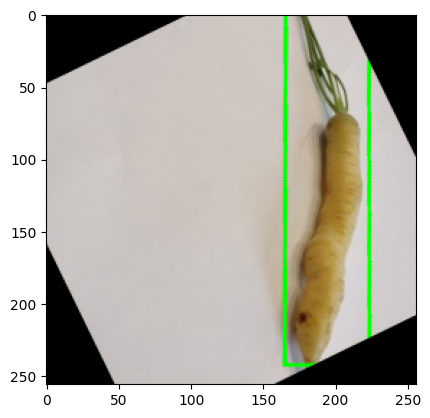

alligned_points [(164, 239), (164, -33), (190, -33), (190, 239)]
clipped aligned_points [(164, 239), (164, 0), (190, 0), (190, 239)]


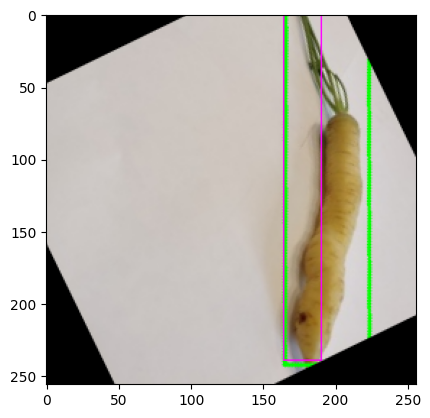

In [68]:
print("old box: ", box)
box = prep.recalculate_bounding_box(box)
print("new box: ", box)
rotated_points = prep.rotate_edge_points(box, rect[2])
print("rotated_points", rotated_points)
rotated_img = prep.rotate_img(vegi_with_box_rgb, rect[2])
prep.show_image_plt(rotated_img)
aligned_points = prep.align_edge_points(rotated_points)
print("alligned_points", aligned_points)
aligned_points = prep.clip_aligned_points(aligned_points)
print("clipped aligned_points", aligned_points)
vegi_with_new_box_rgb = prep.draw_rotated_box(rotated_img, aligned_points)
prep.show_image_plt(vegi_with_new_box_rgb)


The resized image to 256x256 pixels


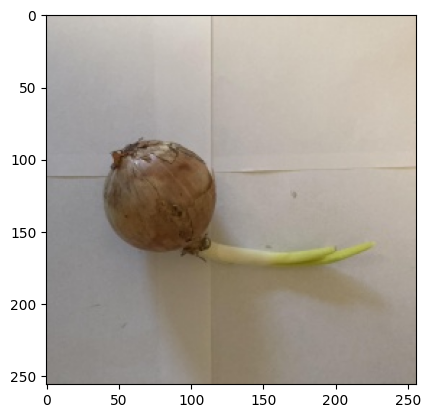

Shows the bounding box which was drawed around the founded contours


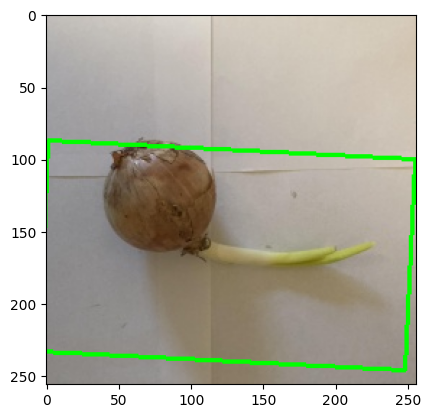

Segmented Binary Image 


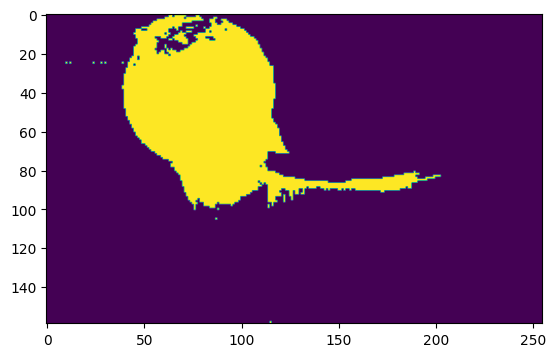

Segmented Image after applying the binary mask


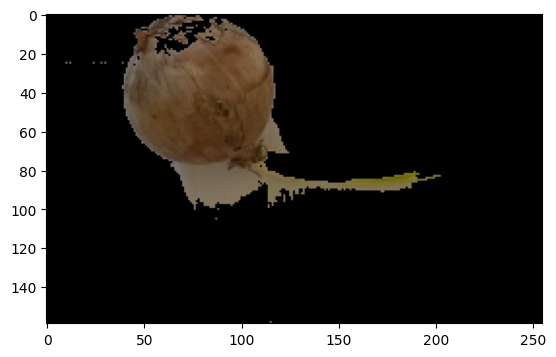

Shows the green color mask to get only the green pixels from the image


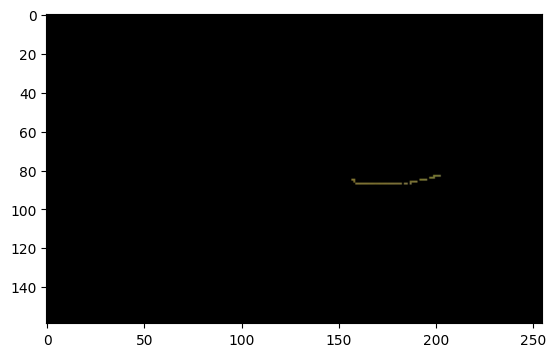

In [8]:
print("The resized image to 256x256 pixels")
prep.show_image_plt(cv2.cvtColor(vegi_sq_BGR_original, cv2.COLOR_BGR2RGB))

print("Shows the bounding box which was drawed around the founded contours")
prep.show_image_plt(vegi_with_box_rgb)

print("Segmented Binary Image ")
prep.show_image_plt(cropped_segmented_binary_2)

print("Segmented Image after applying the binary mask")
prep.show_image_plt(cropped_vegi_segmented_rgb_2)

print("Shows the green color mask to get only the green pixels from the image")
prep.show_image_plt(vegi_only_onion_tribe_rgb)

In [ ]:
#vegis_df.to_csv("G:/Meine Ablage/KI_Projekt/Daten/.csv")